In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [2]:
# import OFRL modules
import ofrl
from rtbgym import RTBEnv, CustomizedRTBEnv
from basicgym import BasicEnv
from ofrl.dataset import SyntheticDataset
from ofrl.policy import BaseHead
from ofrl.policy import OnlineHead, ContinuousEvalHead
from ofrl.policy import ContinuousTruncatedGaussianHead as TruncatedGaussianHead
from ofrl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)
from ofrl.utils import MinMaxScaler, MinMaxActionScaler

# import d3rlpy algorithms
from d3rlpy.algos import RandomPolicy
# from d3rlpy.preprocessing import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MinMaxScaler, MinMaxActionScaler
from ofrl.utils import MultipleLoggedDataset

# import from other libraries
import gym
from gym.spaces import Box
import torch
from sklearn.model_selection import train_test_split
from pathlib import Path
from typing import List

#import from function
from tutorial.function import train_behavior_policy
from tutorial.function import obtain_logged_dataset
from tutorial.function import train_candidate_policies
# from experiments.main import off_policy_evaluation
from tutorial.function import off_policy_evaluation


In [3]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [4]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [5]:
# # standardized environment for discrete action
env = gym.make("BasicEnv-continuous-v0")
# # for api compatibility to d3rlpy
from ofrl.utils import OldGymAPIWrapper
env_ = OldGymAPIWrapper(env)
# # behavior policy
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

In [6]:
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL

In [7]:
# import ope modules from OFRL
from ofrl.ope import CreateOPEInput
from ofrl.ope import OffPolicyEvaluation
# basic estimators
from ofrl.ope import ContinuousDirectMethod as C_DM
from ofrl.ope import ContinuousTrajectoryWiseImportanceSampling as C_TIS
from ofrl.ope import ContinuousPerDecisionImportanceSampling as C_PDIS
from ofrl.ope import ContinuousDoublyRobust as C_DR
# self normalized estimators
from ofrl.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as C_SNTIS
from ofrl.ope import ContinuousSelfNormalizedPerDecisionImportanceSampling as C_SNPDIS
from ofrl.ope import ContinuousSelfNormalizedDoublyRobust as C_SNDR
# marginal estimators
from ofrl.ope import ContinuousStateActionMarginalImportanceSampling as C_SAMIS
from ofrl.ope import ContinuousStateActionMarginalDoublyRobust as C_SAMDR
from ofrl.ope import ContinuousStateMarginalImportanceSampling as C_SMIS
from ofrl.ope import ContinuousStateMarginalDoublyRobust as C_SMDR
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedImportanceSampling as C_SAMSNIS
from ofrl.ope import ContinuousStateActionMarginalSelfNormalizedDoublyRobust as C_SAMSNDR
from ofrl.ope import ContinuousStateMarginalSelfNormalizedImportanceSampling as C_SMSNIS
from ofrl.ope import ContinuousStateMarginalSelfNormalizedDoublyRobust as C_SMSNDR
# double reinforcement learning estimators
from ofrl.ope import ContinuousDoubleReinforcementLearning as C_DRL

In [22]:

env_name="BasicEnv-continuous-v0"
env = gym.make(env_name)
behavior_sigma=1.0
behavior_tau=1.0
candidate_sigmas=[0.0, 0.5]
# candidate_sigmas=[0.0, 0.5, 1.0, 2.0]
candidate_epsilons=[0.1, 0.3]
# candidate_epsilons=[0.1, 0.3, 0.5, 0.7]
max_episode_steps=50
# n_trajectories=10000
n_random_state=2
base_random_state=12345
log_dir="../tutorial/logs/"
device="cuda:0" if torch.cuda.is_available() else "cpu",
n_trajectories_list =  [2, 10, 20]
bias_df_list = []
variance_df_list = []
mse_df_list = []

for n_trajectories in n_trajectories_list:

    behavior_policy = train_behavior_policy(
        env_name=env_name,
        env=env,
        behavior_sigma=behavior_sigma,
        behavior_tau=behavior_tau,
        device=device,
        base_random_state=base_random_state,
        log_dir=log_dir,
    )

    train_logged_dataset, test_logged_dataset = obtain_logged_dataset(
        env_name=env_name,
        env=env,
        behavior_policy=behavior_policy,
        n_trajectories=n_trajectories,
        n_random_state=n_random_state,
        base_random_state=base_random_state,
        log_dir=log_dir,
    )

    candidate_policies = train_candidate_policies(
        env_name=env_name,
        env=env,
        n_trajectories=n_trajectories,
        train_logged_dataset=train_logged_dataset,
        candidate_sigmas=candidate_sigmas,
        candidate_epsilons=candidate_epsilons,
        device=device,
        base_random_state=base_random_state,
        log_dir=log_dir,
    )

    input_dict, policy_value_dict = off_policy_evaluation(
        env_name=env_name,
        env=env,
        n_trajectories=n_trajectories,
        test_logged_dataset=test_logged_dataset,
        candidate_policies=candidate_policies,
        device=device,
        base_random_state=base_random_state,
        # log_dir="logs/",
        log_dir=log_dir,
    )

    input_dict_ = input_dict.get(
        behavior_policy_name="sac_gauss_1.0",
        dataset_id=0,
    )

    dict = {i : DataFrame() for i in input_dict_.keys()}
    bias_dict = {i : 0 for i in input_dict_.keys()}
    variance_dict = {i : 0 for i in input_dict_.keys()}
    mse_dict = {i : 0 for i in input_dict_.keys()}

    for dataset_id_ in range(n_random_state):
        for eval_policy in input_dict_.keys():
            dict[eval_policy] = pd.concat([dict[eval_policy] , DataFrame(policy_value_dict['sac_gauss_1.0'][dataset_id_][eval_policy], index=[dataset_id_])])
    
    print(n_trajectories, policy_value_dict)


    for eval_policy in input_dict_.keys():
        bias_dict[eval_policy] = abs(dict[eval_policy].mean(axis=0) - dict[eval_policy].mean(axis=0)['on_policy'])
        variance_dict[eval_policy] = dict[eval_policy].var(axis=0)
        mse_dict[eval_policy] = bias_dict[eval_policy]**2 + variance_dict[eval_policy]

    # print(n_trajectories, bias_dict)

    bias_df = DataFrame(DataFrame(bias_dict['cql_b1_gauss_0.0']).stack())\
    .reset_index(0).rename(columns={"level_0": "est", 0: "bias"})
    bias_df["n_trajectories"] = n_trajectories
    bias_df_list.append(bias_df)
    variance_df = DataFrame(DataFrame(variance_dict['cql_b1_gauss_0.0']).stack())\
    .reset_index(0).rename(columns={"level_0": "est", 0: "variance"})
    variance_df["n_trajectories"] = n_trajectories
    variance_df_list.append(variance_df)
    mse_df = DataFrame(DataFrame(mse_dict['cql_b1_gauss_0.0']).stack())\
    .reset_index(0).rename(columns={"level_0": "est", 0: "mse"})
    mse_df["n_trajectories"] = n_trajectories
    mse_df_list.append(mse_df)

# aggregate all results 
bias_result_df = pd.concat(bias_df_list).reset_index(level=0)
variance_result_df = pd.concat(variance_df_list).reset_index(level=0)
mse_result_df = pd.concat(mse_df_list).reset_index(level=0)


/Users/ren/.pyenv/versions/3.10.6/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(


[obtain_trajectories]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_datasets: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/2 [00:00<?, ?it/s]

[obtain_trajectories]:   0%|          | 0/2 [00:00<?, ?it/s]

[learn_policies: algorithms]:   0%|          | 0/2 [00:00<?, ?it/s]

2023-04-21 02:35.58 [debug    ] RandomIterator is selected.
2023-04-21 02:35.58 [info     ] Directory is created at d3rlpy_logs/CQL_20230421023558
2023-04-21 02:35.58 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-21 02:35.58 [debug    ] Building models...
2023-04-21 02:35.58 [debug    ] Models have been built.
2023-04-21 02:35.58 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230421023558/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([-1., -1., -1.]), 'maximum': array([1., 1., 1.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, '

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-21 02:41.18 [info     ] CQL_20230421023558: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009389776229858398, 'time_algorithm_update': 0.030172406649589537, 'temp_loss': -3.6544822816467843, 'temp': 1.3230126127958297, 'alpha_loss': 23.781788408971018, 'alpha': 0.6920229102224111, 'critic_loss': -23.688970983906835, 'actor_loss': 19.28939517410677, 'time_step': 0.03172298517227173} step=10000
2023-04-21 02:41.18 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230421023558/model_10000.pt
2023-04-21 02:41.18 [debug    ] RandomIterator is selected.
2023-04-21 02:41.18 [info     ] Directory is created at d3rlpy_logs/CQL_20230421024118
2023-04-21 02:41.18 [debug    ] Fitting action scaler...       action_scaler=min_max
2023-04-21 02:41.18 [debug    ] Building models...
2023-04-21 02:41.18 [debug    ] Models have been built.
2023-04-21 02:41.18 [info     ] Parameters are saved to d3rlpy_logs/CQL_20230421024118/params.json params={'action_scaler': {'type': 'm

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2023-04-21 02:46.11 [info     ] CQL_20230421024118: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0009185099363327026, 'time_algorithm_update': 0.02752301366329193, 'temp_loss': 0.5989849624673137, 'temp': 0.9005616285145283, 'alpha_loss': 10.973549168953673, 'alpha': 0.7818670011490584, 'critic_loss': -10.925186485316791, 'actor_loss': 8.089484787018783, 'time_step': 0.02907041258811951} step=10000
2023-04-21 02:46.11 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20230421024118/model_10000.pt


[collect input data: behavior_policy]:   0%|          | 0/1 [00:00<?, ?it/s]

[collect input data: dataset_id]:   0%|          | 0/2 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ren/dev/ofrl/tutorial/../ofrl/policy/head.py:934: RuntimeWarning: divide by zero encountered in divide
  a=(self.minimum - greedy_action) / self.sigma,
/Users/ren/dev/ofrl/tutorial/../ofrl/policy/head.py:935: RuntimeWarning: divide by zero encountered in divide
  b=(self.maximum - greedy_action) / self.sigma,


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[collect input data: eval_policy]:   0%|          | 0/4 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

['sac_gauss_1.0']
2 {'sac_gauss_1.0': [{'cql_b1_gauss_0.0': {'on_policy': -1.1474967003581975, 'tis': -9.680925852975302e+25, 'snpdis': -0.5241172199585697}, 'cql_b1_gauss_0.5': {'on_policy': -0.5019233295611583, 'tis': -1.3228232024518118e+26, 'snpdis': -0.42400112490784325}, 'cql_b2_gauss_0.0': {'on_policy': -0.5861031328754719, 'tis': -1.242488574475691e+26, 'snpdis': -0.5487119775985795}, 'cql_b2_gauss_0.5': {'on_policy': -0.4433365610036876, 'tis': -4.265407832915773e+25, 'snpdis': -0.27543252422555015}}, {'cql_b1_gauss_0.0': {'on_policy': -1.1474967003581975, 'tis': 1.2851578150916508e+24, 'snpdis': 1.4461494734405331}, 'cql_b1_gauss_0.5': {'on_policy': -0.6638769214712411, 'tis': 2.5223934927921805e+24, 'snpdis': 1.4189624000600243}, 'cql_b2_gauss_0.0': {'on_policy': -0.5861031328754719, 'tis': 1.1264379983851842e+24, 'snpdis': 1.4301072258294958}, 'cql_b2_gauss_0.5': {'on_policy': -0.22280273511837043, 'tis': 2.129399753249198e+24, 'snpdis': 1.4557187225049726}}]}
10 {'sac_gaus

In [12]:
bias_result_df

,index,est,bias,n_trajectories
0,0,on_policy,0.000000e+00,10
1,0,tis,6.515309e+26,10
2,0,snpdis,1.052880e-01,10
3,0,on_policy,0.000000e+00,20
4,0,tis,6.515309e+26,20
5,0,snpdis,1.052880e-01,20


In [13]:
variance_result_df

,index,est,variance,n_trajectories
0,0,on_policy,0.000000e+00,10
1,0,tis,1.211757e+54,10
2,0,snpdis,1.748005e-01,10
3,0,on_policy,0.000000e+00,20
4,0,tis,1.211757e+54,20
5,0,snpdis,1.748005e-01,20


In [14]:
# with open("logs/cql_variance_result_df.pkl", "wb") as f:
#     pickle.dump(variance_result_df, f)

# with open("logs/cql_variance_result_df.pkl", "rb") as f:
#     variance_result_df = pickle.load(f)

# with open("logs/cql_bias_result_df.pkl", "wb") as f:
#     pickle.dump(bias_result_df, f)

# with open("logs/cql_bias_result_df.pkl", "rb") as f:
#     bias_result_df = pickle.load(f)

# with open("logs/cql_mse_result_df.pkl", "wb") as f:
#     pickle.dump(mse_result_df, f)

# with open("logs/cql_mse_result_df.pkl", "rb") as f:
#     mse_result_df = pickle.load(f)

In [15]:
bias_result_df.query("(est == 'tis')")

,index,est,bias,n_trajectories
1,0,tis,6.515309e+26,10
4,0,tis,6.515309e+26,20


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_36872/3133372002.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


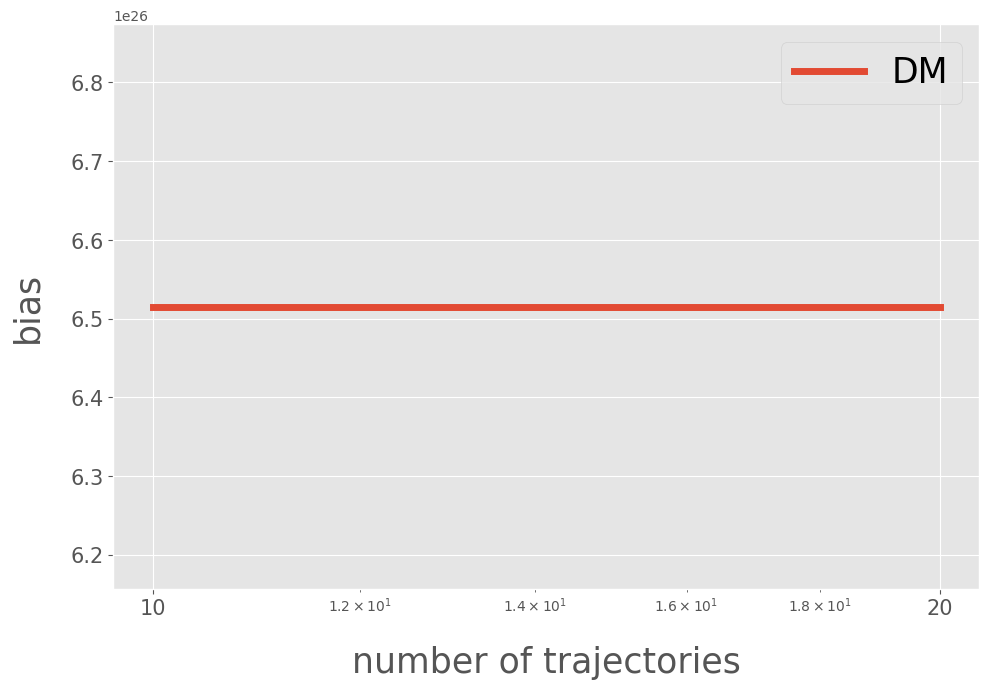

In [16]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [10, 20]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="est",
    ax=ax,
    data=bias_result_df.query("(est == 'tis')"),
    # data=bias_result_df.query("(est == 'dm' or est == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "TIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_36872/786624529.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


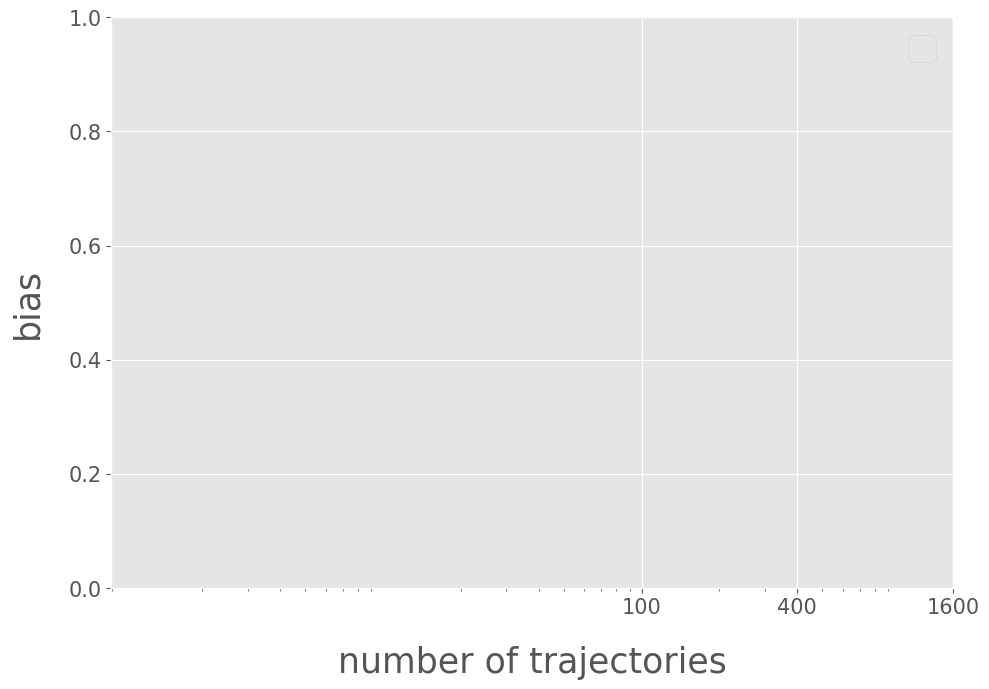

In [17]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="bias",
    hue="index",
    ax=ax,
    data=bias_result_df.query("(est == 'dm' or est == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("bias", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

In [18]:
variance_result_df

,index,est,variance,n_trajectories
0,0,on_policy,0.000000e+00,10
1,0,tis,1.211757e+54,10
2,0,snpdis,1.748005e-01,10
3,0,on_policy,0.000000e+00,20
4,0,tis,1.211757e+54,20
5,0,snpdis,1.748005e-01,20


/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_36872/1079444482.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


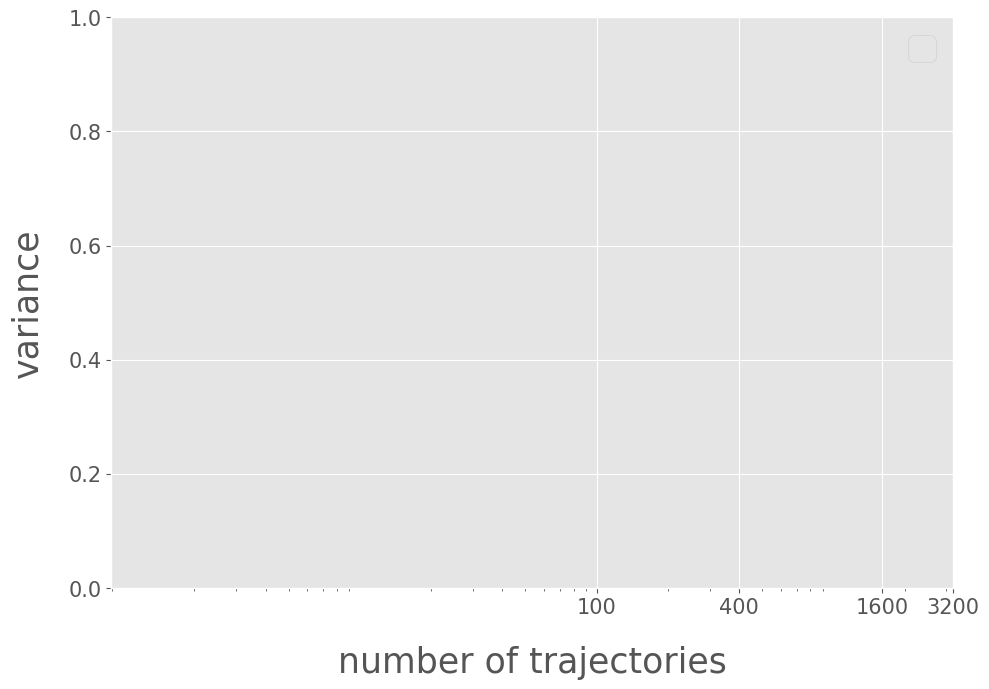

In [19]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600, 3200]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'dm' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["DM", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_36872/1525150744.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


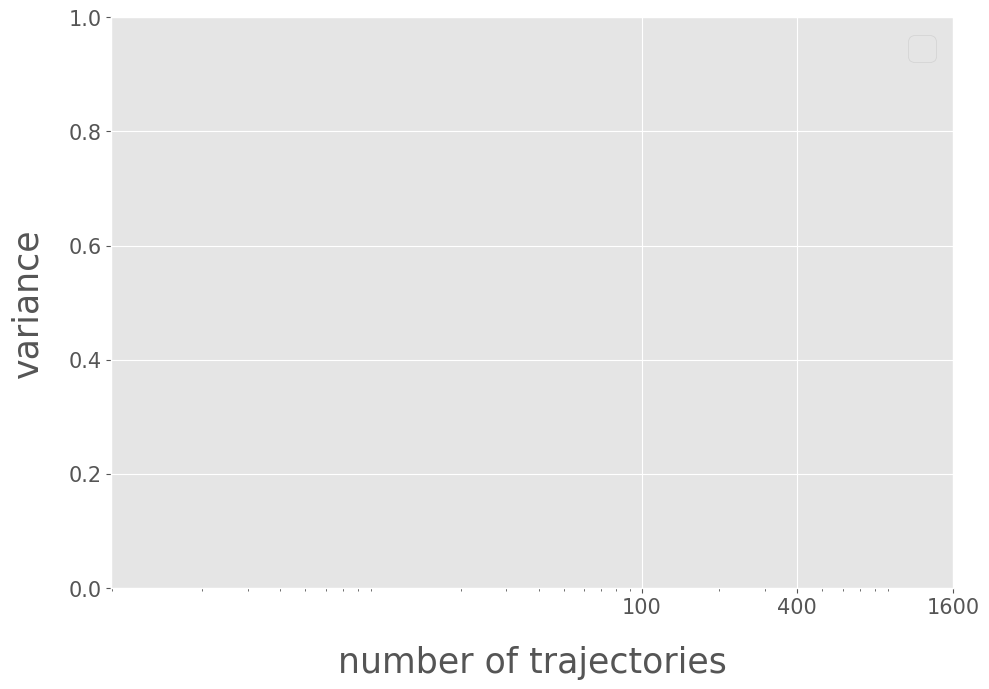

In [20]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'tis' or index == 'pdis')"),
    ci=None,
)
# title and legend
ax.legend(["TIS", "PDIS"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)

/var/folders/48/ly7vft814qv_x6krlfw5s8_c0000gn/T/ipykernel_36872/3324735909.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


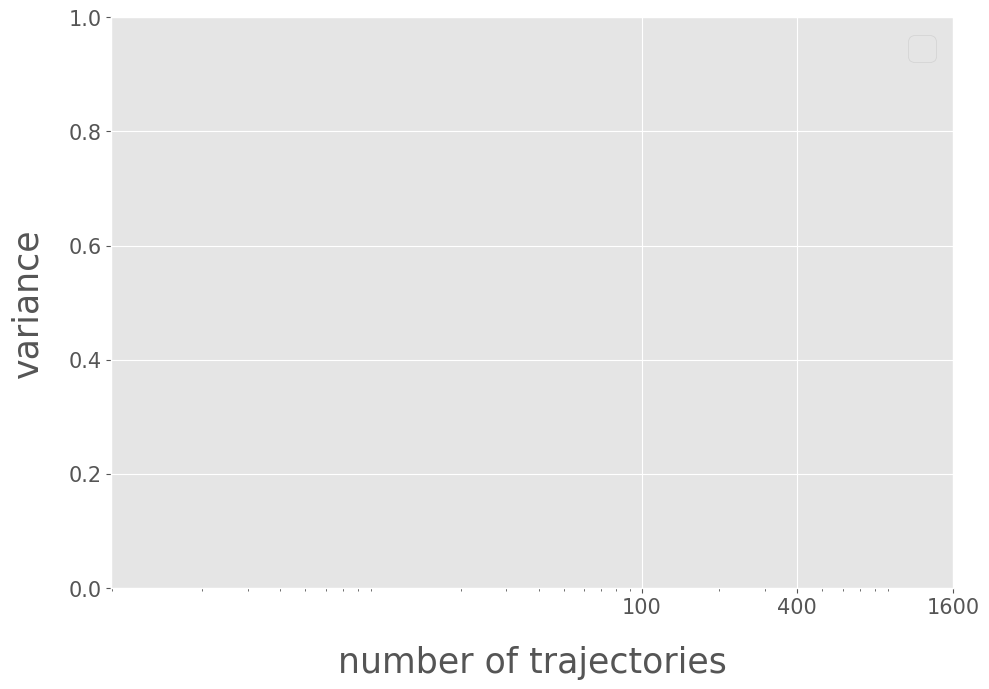

In [21]:
# figure configs
# query = "(est == 'DM' or est == 'IPS') and num_data <= 6400"
xlabels = [100, 400, 1600]

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 7), tight_layout=True)
sns.lineplot(
    linewidth=5,
    dashes=False,
    legend=False,
    x="n_trajectories",
    y="variance",
    hue="index",
    ax=ax,
    data=variance_result_df.query("(index == 'pdis' or index == 'dr')"),
    ci=None,
)
# title and legend
ax.legend(["PDIS", "DR"], loc="upper right", fontsize=25)
# yaxis
# ax.set_yscale("log")
ax.set_ylabel("variance", fontsize=25)
ax.tick_params(axis="y", labelsize=15)
ax.yaxis.set_label_coords(-0.08, 0.5)
# xaxis
ax.set_xscale("log")
ax.set_xlabel("number of trajectories", fontsize=25)
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels, fontsize=15)
ax.xaxis.set_label_coords(0.5, -0.1)